In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.api._v2.keras import layers
from keras.layers import Input, concatenate
from keras.models import Model
import numpy as np
from numpy import loadtxt
import numba as nb
import math

In [2]:

# Number of transmitter-receiver pairs
K = 5

# Minimum rate for the achievable SINR of multiple concurrent transmissions
SINR_P_min = tf.constant([0.2, 0.2, 0.2, 0.2, 0.2], dtype=tf.float32)

# Maximum transmit power
PMax = tf.constant(1.0, dtype=tf.float32)


In [3]:

# Variances for noise signals at different dB levels
sigma_sqr_noise_0dB = np.full(5, 1e-0, dtype=float)
sigma_sqr_noise_10dB = np.full(5, 1e-1, dtype=float)
sigma_sqr_noise_20dB = np.full(5, 1e-2, dtype=float)
sigma_sqr_noise_30dB = np.full(5, 1e-3, dtype=float)
sigma_sqr_noise_40dB = np.full(5, 1e-4, dtype=float)


In [4]:

# Function to load and reshape the CSV files into 3D arrays
def load_and_reshape(file_path, K):
    # Load the CSV file as a 2D array
    FH2D = loadtxt(file_path, delimiter=',', dtype=str)
    
    # Reshape the 2D array into a 3D array
    FH3D = FH2D.reshape(FH2D.shape[0], -1, K)
    
    # Return the reshaped array and its size
    return FH3D, FH3D.shape[0]

# Loading and reshaping the arrays from CSV files
FH3D_0dB, FH3D_0dB_size = load_and_reshape('F_H_2D_0dB_K5.csv', K=5)
FH3D_10dB, FH3D_10dB_size = load_and_reshape('F_H_2D_10dB_K5.csv', K=5)
FH3D_20dB, FH3D_20dB_size = load_and_reshape('F_H_2D_20dB_K5.csv', K=5)
FH3D_30dB, FH3D_30dB_size = load_and_reshape('F_H_2D_30dB_K5.csv', K=5)
FH3D_40dB, FH3D_40dB_size = load_and_reshape('F_H_2D_40dB_K5.csv', K=5)



In [5]:

# Function to convert string data to complex data and remove initial whitespace using vectorized operations
def cnvrt_2_cmplx_data(FH3D_size, FH3D):
    # Use np.char.strip to remove initial whitespace from the entire 3D array
    FH3D_stripped = np.char.strip(FH3D)
    
    # Convert the stripped string array to complex numbers using vectorized conversion
    FHCmplx = FH3D_stripped.astype(np.complex_)
    
    # Reshape the array directly to the desired shape (H_size, K, K)
    F_H = FHCmplx.reshape(FH3D_size, K, K)
    
    return F_H


In [6]:
## Converting string data to complex data and removing the initial whitespace
F_H_0dB = cnvrt_2_cmplx_data(FH3D_0dB_size, FH3D_0dB)
F_H_10dB = cnvrt_2_cmplx_data(FH3D_10dB_size, FH3D_10dB)
F_H_20dB = cnvrt_2_cmplx_data(FH3D_20dB_size, FH3D_20dB)
F_H_30dB = cnvrt_2_cmplx_data(FH3D_30dB_size, FH3D_30dB)
F_H_40dB = cnvrt_2_cmplx_data(FH3D_40dB_size, FH3D_40dB)

print(F_H_0dB.shape)
print(F_H_10dB.shape)
print(F_H_20dB.shape)
print(F_H_30dB.shape)
print(F_H_40dB.shape)

F_H_0dB_size = F_H_0dB.shape[0]
F_H_10dB_size = F_H_10dB.shape[0]
F_H_20dB_size = F_H_20dB.shape[0]
F_H_30dB_size = F_H_30dB.shape[0]
F_H_40dB_size = F_H_40dB.shape[0]


(250000, 5, 5)
(250000, 5, 5)
(250000, 5, 5)
(250000, 5, 5)
(250000, 5, 5)


In [7]:
print(F_H_0dB)
# print(F_H_10dB)
# print(F_H_20dB)
# print(F_H_30dB)
# print(F_H_40dB)

[[[-1.23631937+0.22921883j -0.54667901-0.20138914j
   -0.47946164+0.498344j    0.3113009 -0.22798014j
    0.69691993-0.88261167j]
  [-0.14673233-0.67982819j  1.05716624-0.17533585j
    1.40408283-0.3634557j  -0.01055404-0.70807464j
   -0.25915166+0.60921694j]
  [ 0.78419976-0.33361193j  0.40834267+1.0118874j
   -0.96713008-0.16796663j -0.6647029 -0.7954383j
    0.02752075-0.71561235j]
  [ 0.3465332 -0.09099838j -0.4367235 +1.37334099j
    0.7779833 +0.29038137j -0.05983818+0.77268389j
    0.50615944-0.15630014j]
  [ 0.53521481-0.13481686j  1.21080065-0.03027252j
   -0.48457478+0.57532919j  0.01145698-0.21696277j
    1.17455914+1.17218511j]]

 [[ 0.79699507+0.63304366j  0.01760131+0.32898345j
    0.05801209+0.55645257j  0.38766506-0.43073101j
   -0.45751618-0.60856057j]
  [-0.26554943-0.92245427j -0.85025071+0.87457213j
    0.29233821+0.99113017j -1.19413667-0.06657383j
    0.12229737+0.16174348j]
  [-0.10512262-1.25990919j -0.40637738-0.68602838j
    0.01210378-1.02630839j  0.47588371-

In [8]:
# Function to compute the square of the absolute value of a complex tensor
def cmplx_abs_sqr(cmplx_var):
    # Calculate the squared magnitude of the complex numbers
    return tf.math.square(tf.math.real(cmplx_var)) + tf.math.square(tf.math.imag(cmplx_var))

In [9]:
# Function to generate the matrix A (K x K) using TensorFlow functions
def generate_A(F_H_size, K, SINR_P_min, F_H):
    # Calculate the squared magnitude of the complex matrix and cast to float32
    F_H_abs_sqr = tf.cast(cmplx_abs_sqr(F_H), dtype=tf.float32)

    # Create an identity matrix for selecting diagonal elements (float32)
    identity_matrix = tf.eye(K, dtype=tf.float32)

    # Expand SINR_P_min to match dimensions for broadcasting and cast to float32
    SINR_P_min_expanded = tf.expand_dims(tf.cast(SINR_P_min, dtype=tf.float32), axis=-1)  # Shape: (K, 1)

    # Create the matrix A using TensorFlow operations
    Aij = tf.where(
        tf.equal(identity_matrix, 1),  # Condition to keep diagonal elements
        F_H_abs_sqr,                   # Use F_H_abs_sqr for diagonal elements
        -SINR_P_min_expanded * F_H_abs_sqr  # Multiply off-diagonal elements by -SINR_P_min
    )

    # Reshape the resulting array to (F_H_size, K, K)
    Aij = tf.reshape(Aij, (F_H_size, K, K))

    return Aij


In [10]:
import tensorflow as tf

# Function to generate the vector b (K x 1) using TensorFlow operations
def generate_b(F_H_size, K, SINR_P_min, sigma_sqr_noise, F_H):
    # Calculate the vector b by broadcasting SINR_P_min and sigma_sqr_noise
    b = tf.multiply(SINR_P_min, sigma_sqr_noise)  # Element-wise multiplication
    
    # Reshape to (1, K, 1) to match dimensions for broadcasting
    b = tf.reshape(b, (1, K, 1))

    # Repeat this result across the F_H_size dimension
    bi = tf.repeat(b, repeats=F_H_size, axis=0)
    
    return bi



In [11]:

# Function to split datasets into training, validation, and testing
def split(np_array):
    # Define fixed sizes for training, validation, and testing datasets
    train_data_size = 200000
    valid_data_size = 25000
    test_data_size = 25000

    # Calculate the indices for slicing the dataset
    train_e_indx = train_data_size
    valid_e_indx = train_e_indx + valid_data_size
    test_e_indx = valid_e_indx + test_data_size

    # Slice the input array into training, validation, and testing datasets
    train_data = np_array[:train_e_indx]
    valid_data = np_array[train_e_indx:valid_e_indx]
    test_data = np_array[valid_e_indx:test_e_indx]

    # Calculate the absolute values of the datasets
    train_input = np.abs(train_data)
    valid_input = np.abs(valid_data)
    test_input = np.abs(test_data)

    # Print the shapes to verify correctness
    print(train_input.shape, valid_input.shape, test_input.shape)

    # Return the split datasets
    return [train_input, valid_input, test_input, test_data]


In [12]:
# List of F_H matrices
F_H_matrices = [F_H_0dB, F_H_10dB, F_H_20dB, F_H_30dB, F_H_40dB]

# Split each matrix and assign the results to corresponding variables
splits = [split(F_H) for F_H in F_H_matrices]

(train_input_F_H_0dB, valid_input_F_H_0dB, test_input_F_H_0dB, test_data_F_H_0dB), \
(train_input_F_H_10dB, valid_input_F_H_10dB, test_input_F_H_10dB, test_data_F_H_10dB), \
(train_input_F_H_20dB, valid_input_F_H_20dB, test_input_F_H_20dB, test_data_F_H_20dB), \
(train_input_F_H_30dB, valid_input_F_H_30dB, test_input_F_H_30dB, test_data_F_H_30dB), \
(train_input_F_H_40dB, valid_input_F_H_40dB, test_input_F_H_40dB, test_data_F_H_40dB) = splits


(200000, 5, 5) (25000, 5, 5) (25000, 5, 5)
(200000, 5, 5) (25000, 5, 5) (25000, 5, 5)
(200000, 5, 5) (25000, 5, 5) (25000, 5, 5)
(200000, 5, 5) (25000, 5, 5) (25000, 5, 5)
(200000, 5, 5) (25000, 5, 5) (25000, 5, 5)


In [129]:
# # List of p_hat vectors
# p_hat_vectors = [p_hat_0dB, p_hat_10dB, p_hat_20dB, p_hat_30dB, p_hat_40dB]

# # Split each vector and assign the results to corresponding variables
# p_hat_splits = [split(p_hat) for p_hat in p_hat_vectors]

# (train_input_p_hat_0dB, valid_input_p_hat_0dB, test_input_p_hat_0dB, test_data_p_hat_0dB), \
# (train_input_p_hat_10dB, valid_input_p_hat_10dB, test_input_p_hat_10dB, test_data_p_hat_10dB), \
# (train_input_p_hat_20dB, valid_input_p_hat_20dB, test_input_p_hat_20dB, test_data_p_hat_20dB), \
# (train_input_p_hat_30dB, valid_input_p_hat_30dB, test_input_p_hat_30dB, test_data_p_hat_30dB), \
# (train_input_p_hat_40dB, valid_input_p_hat_40dB, test_input_p_hat_40dB, test_data_p_hat_40dB) = p_hat_splits


In [13]:
# List of sizes and dB levels
sizes = [F_H_0dB_size, F_H_10dB_size, F_H_20dB_size, F_H_30dB_size, F_H_40dB_size]
dB_levels = [0, 10, 20, 30, 40]

# Create EsN0 arrays and reshape into vectors using TensorFlow
EsN0_arrays = [tf.fill([size, 1], dB) for size, dB in zip(sizes, dB_levels)]

# Unpack into variables
(EsN0_vector_0dB, EsN0_vector_10dB, EsN0_vector_20dB, 
 EsN0_vector_30dB, EsN0_vector_40dB) = EsN0_arrays

# Print shapes of the vectors
print(EsN0_vector_0dB.shape)
print(EsN0_vector_10dB.shape)
print(EsN0_vector_20dB.shape)
print(EsN0_vector_30dB.shape)
print(EsN0_vector_40dB.shape)



(250000, 1)
(250000, 1)
(250000, 1)
(250000, 1)
(250000, 1)


In [14]:
# Function to split EsN0 vector for training, validation, and testing
def split_EsN0(tf_vector):
    # Define fixed sizes for training, validation, and testing datasets
    train_data_size = 200000
    valid_data_size = 25000
    test_data_size = 25000

    # Calculate indices for slicing
    train_e_indx = train_data_size
    valid_e_indx = train_e_indx + valid_data_size
    test_e_indx = valid_e_indx + test_data_size

    # Slice the tensor directly into training, validation, and testing datasets using TensorFlow
    train_data = tf.reshape(tf_vector[:train_e_indx], (train_data_size, -1, 1))
    valid_data = tf.reshape(tf_vector[train_e_indx:valid_e_indx], (valid_data_size, -1, 1))
    test_data = tf.reshape(tf_vector[valid_e_indx:test_e_indx], (test_data_size, -1, 1))

    # Calculate the absolute values (if needed)
    train_input = tf.abs(train_data)
    valid_input = tf.abs(valid_data)
    test_input = tf.abs(test_data)

    # Print shapes to verify correctness
    print(train_input.shape, valid_input.shape, test_input.shape)

    # Return the split datasets
    return [train_input, valid_input, test_input, test_data]



In [15]:
# List of EsN0 vectors
EsN0_vectors = [EsN0_vector_0dB, EsN0_vector_10dB, EsN0_vector_20dB, EsN0_vector_30dB, EsN0_vector_40dB]

# Split each EsN0 vector
EsN0_splits = [split_EsN0(EsN0) for EsN0 in EsN0_vectors]

# Unpack the split results into corresponding variables
(train_input_EsN0_0dB, valid_input_EsN0_0dB, test_input_EsN0_0dB, test_data_EsN0_0dB), \
(train_input_EsN0_10dB, valid_input_EsN0_10dB, test_input_EsN0_10dB, test_data_EsN0_10dB), \
(train_input_EsN0_20dB, valid_input_EsN0_20dB, test_input_EsN0_20dB, test_data_EsN0_20dB), \
(train_input_EsN0_30dB, valid_input_EsN0_30dB, test_input_EsN0_30dB, test_data_EsN0_30dB), \
(train_input_EsN0_40dB, valid_input_EsN0_40dB, test_input_EsN0_40dB, test_data_EsN0_40dB) = EsN0_splits



(200000, 1, 1) (25000, 1, 1) (25000, 1, 1)
(200000, 1, 1) (25000, 1, 1) (25000, 1, 1)
(200000, 1, 1) (25000, 1, 1) (25000, 1, 1)
(200000, 1, 1) (25000, 1, 1) (25000, 1, 1)
(200000, 1, 1) (25000, 1, 1) (25000, 1, 1)


In [16]:
# List of input arrays for F_H and EsN0
train_inputs_F_H = [train_input_F_H_0dB, train_input_F_H_10dB, 
                    train_input_F_H_20dB, train_input_F_H_30dB, 
                    train_input_F_H_40dB]

train_inputs_EsN0 = [train_input_EsN0_0dB, train_input_EsN0_10dB, 
                     train_input_EsN0_20dB, train_input_EsN0_30dB, 
                     train_input_EsN0_40dB]

# Stack the datasets vertically using TensorFlow's tf.concat
train_input_F_H = tf.concat(train_inputs_F_H, axis=0)
train_input_EsN0 = tf.concat(train_inputs_EsN0, axis=0)

# Print shapes to verify correctness
print(train_input_F_H.shape)
print(train_input_EsN0.shape)



(1000000, 5, 5)
(1000000, 1, 1)


In [17]:
# List of validation input arrays for F_H and EsN0
valid_inputs_F_H = [valid_input_F_H_0dB, valid_input_F_H_10dB, 
                    valid_input_F_H_20dB, valid_input_F_H_30dB, 
                    valid_input_F_H_40dB]

valid_inputs_EsN0 = [valid_input_EsN0_0dB, valid_input_EsN0_10dB, 
                     valid_input_EsN0_20dB, valid_input_EsN0_30dB, 
                     valid_input_EsN0_40dB]

# Stack the datasets vertically using TensorFlow's tf.concat
valid_input_F_H = tf.concat(valid_inputs_F_H, axis=0)
valid_input_EsN0 = tf.concat(valid_inputs_EsN0, axis=0)

# Print shapes to verify correctness
print(valid_input_F_H.shape)
print(valid_input_EsN0.shape)



(125000, 5, 5)
(125000, 1, 1)


In [18]:
# Shuffling the training datasets using TensorFlow
train_shuffler = tf.random.shuffle(tf.range(tf.shape(train_input_F_H)[0]))

train_input_F_H_shuffled = tf.gather(train_input_F_H, train_shuffler)
train_input_EsN0_shuffled = tf.gather(train_input_EsN0, train_shuffler)


In [19]:
# Shuffling the validation datasets using TensorFlow
valid_shuffler = tf.random.shuffle(tf.range(tf.shape(valid_input_F_H)[0]))

valid_input_F_H_shuffled = tf.gather(valid_input_F_H, valid_shuffler)
valid_input_EsN0_shuffled = tf.gather(valid_input_EsN0, valid_shuffler)


In [20]:
# Constants
const = K * K
len1 = tf.shape(train_input_F_H_shuffled)[0]

# Reshape train_input_F_H_shuffled using TensorFlow's reshape function
train_input_F_H_shuffled_reshaped = tf.reshape(train_input_F_H_shuffled, (len1, 1, const))  # size X row X column

# Ensure both tensors are of the same type, e.g., float32
train_input_F_H_shuffled_reshaped = tf.cast(train_input_F_H_shuffled_reshaped, dtype=tf.float32)
train_input_EsN0_shuffled = tf.cast(train_input_EsN0_shuffled, dtype=tf.float32)

# Concatenate reshaped F_H and EsN0 inputs using TensorFlow's concat function
train_y_true = tf.concat([train_input_F_H_shuffled_reshaped, train_input_EsN0_shuffled], axis=2)

# Remove the dimension of size 1 in the middle
#train_y_true = tf.squeeze(train_y_true, axis=1)

# Print the shape of the result
print(tf.shape(train_y_true))  # Expected output: [1000000, 26]



tf.Tensor([1000000       1      26], shape=(3,), dtype=int32)


In [138]:
# # Constants
# const = K * K
# len1 = tf.shape(train_input_F_H_shuffled)[0]

# # Reshape train_input_F_H_shuffled using TensorFlow's reshape function
# train_input_F_H_shuffled_reshaped = tf.reshape(train_input_F_H_shuffled, (len1, 1, const))  # size X row X column

# # Concatenate reshaped F_H and EsN0 inputs using TensorFlow's concat function
# train_y_true = tf.concat([train_input_F_H_shuffled_reshaped, train_input_EsN0_shuffled], axis=2)

# # Print the shape of the result
# print(tf.shape(train_y_true))

# # Ensure both tensors are of the same type, e.g., float32
# train_input_F_H_shuffled_reshaped = tf.cast(train_input_F_H_shuffled_reshaped, dtype=tf.float32)
# train_input_EsN0_shuffled = tf.cast(train_input_EsN0_shuffled, dtype=tf.float32)

# # Concatenate reshaped F_H and EsN0 inputs using TensorFlow's concat function
# train_y_true = tf.concat([train_input_F_H_shuffled_reshaped, train_input_EsN0_shuffled], axis=2)

# # Print the shape of the result
# print(tf.shape(train_y_true))





In [21]:
# Reshape valid_input_F_H_shuffled
len2 = tf.shape(valid_input_F_H_shuffled)[0]

# Reshape using TensorFlow
valid_input_F_H_shuffled_reshaped = tf.reshape(valid_input_F_H_shuffled, [len2, 1, const])  # size X row X column

# Ensure both tensors are of the same data type, for example, float32
valid_input_F_H_shuffled_reshaped = tf.cast(valid_input_F_H_shuffled_reshaped, dtype=tf.float32)
valid_input_EsN0_shuffled = tf.cast(valid_input_EsN0_shuffled, dtype=tf.float32)

# Concatenate reshaped F_H and EsN0 inputs using TensorFlow
valid_y_true = tf.concat([valid_input_F_H_shuffled_reshaped, valid_input_EsN0_shuffled], axis=2)

#valid_y_true = tf.squeeze(valid_y_true, axis=1) 

# Print the shape of the result using TensorFlow
print(tf.shape(valid_y_true))

#print(valid_y_true.shape)




tf.Tensor([125000      1     26], shape=(3,), dtype=int32)


In [22]:
## Define the DNN model - The Functional API

hij_inputs = keras.Input(shape=(K,K), name = "hij_inputs")
Flatten_1 = layers.Flatten(name = "flatten_layer_hij")(hij_inputs)

EsN0_inputs = keras.Input(shape=(1,1), name = "EsN0_inputs")
Flatten_2 = layers.Flatten(name = "Flatten_Layer_EsN0")(EsN0_inputs)

concat_layers = concatenate([Flatten_1, Flatten_2])

Dense_1 = layers.Dense(2*K*K, activation="relu", name = "Dense_layer_1")(concat_layers)
BN_1 = layers.BatchNormalization(name = "BN_Layer_1")(Dense_1)

Dense_2 = layers.Dense(K*K, activation="relu", name = "Dense_Layer_2")(BN_1)
BN_2 = layers.BatchNormalization(name = "BN_Layer_2")(Dense_2)

P_hat = layers.Dense(K, activation="sigmoid", name = "P_hat")(BN_2)

model = keras.Model(inputs = [hij_inputs, EsN0_inputs], outputs = P_hat, name = "Functional_Api")
model.summary()

Model: "Functional_Api"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 hij_inputs (InputLayer)        [(None, 5, 5)]       0           []                               
                                                                                                  
 EsN0_inputs (InputLayer)       [(None, 1, 1)]       0           []                               
                                                                                                  
 flatten_layer_hij (Flatten)    (None, 25)           0           ['hij_inputs[0][0]']             
                                                                                                  
 Flatten_Layer_EsN0 (Flatten)   (None, 1)            0           ['EsN0_inputs[0][0]']            
                                                                                     

In [23]:
## Convert SINR_P_min from numpy array to tensor
SINR_P_min_t = tf.convert_to_tensor(SINR_P_min, dtype = float)
tf.print(SINR_P_min_t)

[0.2 0.2 0.2 0.2 0.2]


In [24]:
def generate_A_tilda(A, K):
    # Identity matrix of size K x K
    I = tf.eye(K)
    
    # Negative identity matrix
    neg_I = -I

    # Repeat the identity and negative identity across batch dimension (1000)
    I_batch = tf.tile(tf.expand_dims(I, axis=0), [A.shape[0], 1, 1])
    neg_I_batch = tf.tile(tf.expand_dims(neg_I, axis=0), [A.shape[0], 1, 1])

    # Concatenate I, -I, and A to form A_tilda
    A_tilda = tf.concat([I_batch, neg_I_batch, A], axis=1)

    return A_tilda


In [25]:
def generate_B_tilda(B, K):
    # Zero vector of size K
    zeros = tf.zeros_like(B)
    ones = tf.ones_like(B) * -PMax

    # Reshape B to match the required dimensions
    B_reshaped = tf.reshape(B, (-1, K, 1))

    # Concatenate zeros and B to form B_tilda
    B_tilda = tf.concat([zeros, ones, B_reshaped], axis=1)

    return B_tilda


In [26]:
def transpose_A_tilda(A_tilda):
    return tf.transpose(A_tilda, perm=[0, 2, 1])


In [27]:
# Customized loss function that penalizes the constraint violation
def custom_loss_DC3(y_true, y_pred):
    # Multiply predicted values by p_max
    p = tf.multiply(PMax, y_pred)
    p = tf.reshape(p, (-1, K, 1))

    
  

    eta = 1e-3
        

    # Extract EsN0 value and reshape y_true to exclude EsN0 column
    mtrx_elmnt = K * K
    EsN0_val = y_true[:, 0, mtrx_elmnt]
    y_true_updt = y_true[:, :, :-1]

    # Determine noise variance based on EsN0 value
    sigma_sqr_noise_lf = tf.where(EsN0_val < 10, 1e-0,
                                  tf.where(EsN0_val < 20, 1e-1,
                                           tf.where(EsN0_val < 30, 1e-2,
                                                    tf.where(EsN0_val < 40, 1e-3, 1e-4))))

    # Reshape y_true to form hij matrix and calculate squared magnitudes
    hij = tf.reshape(y_true_updt[:, 0:K*K], (-1, K, K))
    hij_abs_sqr = tf.square(tf.abs(hij))



      ## Create matrix A
    A = generate_A(hij.shape[0], K, SINR_P_min, hij)
    b = generate_b(hij.shape[0], K, SINR_P_min, sigma_sqr_noise_0dB, hij)
    
    B = tf.reshape(b, (-1, K, 1))


    

    # Define A_tilda, b_tilda, A_transpose_tilda
     ## Compute A_tilda and B_tilda
    A_tilda = generate_A_tilda(A, K)
    B_tilda = generate_B_tilda(B, K)

    ## Transpose A_tilda
    A_tilda_T = transpose_A_tilda(A_tilda)

    
    # Gradient Descent for Correction
    for i in range(5):
         # V = tf.linalg.matmul(A_tilda , p )  - b_tilda
         V = B_tilda - tf.linalg.matmul(A_tilda, p)
         V_relu = tf.nn.relu(V)
         gd   = 2 * tf.linalg.matmul( A_tilda_T ,V_relu)
         p = p + eta * gd
         

             
    # # Calculate interference and SINR for each transmitter-receiver pair
    #ph = tf.reduce_sum(tf.multiply(p[:, tf.newaxis], hij_abs_sqr), axis=2)  # Interference + noise

    ph = tf.reduce_sum(tf.multiply(p, hij_abs_sqr), axis=2) 
    diag_part_expanded = tf.expand_dims(tf.linalg.diag_part(hij_abs_sqr), axis=-1)
    numr = tf.multiply(p, diag_part_expanded)  # Signal power (numerator)
    sigma_sqr_noise_lf_expanded = tf.expand_dims(sigma_sqr_noise_lf, axis=-1)
    dnumr = sigma_sqr_noise_lf_expanded + ph - tf.squeeze(numr, axis=-1)
    SINR_i = tf.divide(tf.squeeze(numr, axis=-1), dnumr)
    
    #numr = tf.multiply(p, tf.linalg.diag_part(hij_abs_sqr))  # Signal power (numerator)
    #dnumr = sigma_sqr_noise_lf[:, tf.newaxis] + ph - numr  # Denominator of SINR
    #SINR_i = tf.divide(numr, dnumr)  # SINR values
    R_P = tf.reduce_sum(tf.math.log(1 + SINR_i) / tf.math.log(2.0), axis=1)  # Sum rate
    

    






    # p1 = tf.reshape(p, (-1, K, 1))

    w = PMax - p
    
    A_p = tf.matmul(A, p)

    #B = tf.reshape(b, (-1, K, 1))
   
    s = B - A_p


    # Apply ReLU to the constraint violation
    constraint_violation = tf.nn.relu(tf.concat([p, w, s],axis=1))
    
    # L2 norm of the constraint violation
    penalty_term = tf.reduce_sum(tf.square(constraint_violation), axis=1)  # ||ReLU(gx(y))||^2


    # Final loss calculation

    # lambda_l = 5.0
    lambda_l = 10.0
    # lambda_l = 15.0
    # lambda_l = 20.0
    # lambda_l = 25.0

    loss = -R_P + lambda_l * penalty_term
    return tf.reduce_mean(loss)  # Batch mean loss





In [146]:
# def custom_loss_DC3(y_true, y_pred):
#     # Multiply predicted values by PMax
#     p = tf.multiply(PMax, y_pred)  # p: [batch_size, K, 1]
#     p = tf.reshape(p, (-1, K, 1))  # Ensure p has shape [batch_size, K, 1]

#     eta = 1e-3

#     # Extract EsN0 value and reshape y_true to exclude EsN0 column
#     mtrx_elmnt = K * K
#     EsN0_val = y_true[:, 0, mtrx_elmnt]
#     y_true_updt = y_true[:, :, :-1]

#     # Determine noise variance based on EsN0 value
#     sigma_sqr_noise_lf = tf.where(
#         EsN0_val < 10, 1e-0,
#         tf.where(EsN0_val < 20, 1e-1,
#                  tf.where(EsN0_val < 30, 1e-2,
#                           tf.where(EsN0_val < 40, 1e-3, 1e-4))))
#     sigma_sqr_noise_lf = tf.reshape(sigma_sqr_noise_lf, (-1, 1, 1))  # Shape: [batch_size, 1, 1]

#     # Reshape y_true to form hij matrix and calculate squared magnitudes
#     hij = tf.reshape(y_true_updt[:, 0:K*K], (-1, K, K))  # Shape: [batch_size, K, K]
#     hij_abs_sqr = tf.square(tf.abs(hij))  # Shape: [batch_size, K, K]

#     # Generate matrices A and b (assuming these functions are defined)
#     A = generate_A(hij.shape[0], K, SINR_P_min, hij)
#     b = generate_b(hij.shape[0], K, SINR_P_min, sigma_sqr_noise_0dB, hij)

#     # Define A_tilda, b_tilda, A_transpose_tilda
#     A_tilda = generate_A_tilda(A, K)
#     B_tilda = generate_B_tilda(b, K)
#     A_tilda_T = transpose_A_tilda(A_tilda)

#     # Gradient Descent for Correction
#     for i in range(5):
#         V = B_tilda - tf.linalg.matmul(A_tilda, p)
#         V_relu = tf.nn.relu(V)
#         gd = 2 * tf.linalg.matmul(A_tilda_T, V_relu)
#         p = p + eta * gd

#     # Ensure p remains of shape [batch_size, K, 1]

#     # Compute ph (Interference + noise)
#     p_expanded = tf.expand_dims(p, axis=1)  # Shape: [batch_size, 1, K, 1]
#     hij_abs_sqr_expanded = tf.expand_dims(hij_abs_sqr, axis=-1)  # Shape: [batch_size, K, K, 1]

#     # Multiply p and hij_abs_sqr
#     ph_intermediate = tf.multiply(p_expanded, hij_abs_sqr_expanded)  # Shape: [batch_size, K, K, 1]
#     ph = tf.reduce_sum(ph_intermediate, axis=2)  # Sum over interfering users; shape: [batch_size, K, 1]

#     # Compute numr (Signal power numerator)
#     diag_hij_abs_sqr = tf.linalg.diag_part(hij_abs_sqr)  # Shape: [batch_size, K]
#     diag_hij_abs_sqr = tf.expand_dims(diag_hij_abs_sqr, axis=-1)  # Shape: [batch_size, K, 1]
#     numr = tf.multiply(p, diag_hij_abs_sqr)  # Shape: [batch_size, K, 1]

#     # Compute dnumr (Denominator of SINR)
#     dnumr = sigma_sqr_noise_lf + ph - numr  # Shape: [batch_size, K, 1]

#     # Compute SINR
#     SINR_i = tf.divide(numr, dnumr)  # Shape: [batch_size, K, 1]

#     # Compute sum rate R_P
#     R_P = tf.reduce_sum(tf.math.log(1 + SINR_i) / tf.math.log(2.0), axis=1)  # Shape: [batch_size, 1]

#     # Constraint terms
#     w = PMax - p  # Shape: [batch_size, K, 1]
#     A_p = tf.linalg.matmul(A, p)  # Ensure A is of shape [batch_size, K, K], p: [batch_size, K, 1]; result: [batch_size, K, 1]
#     s = b - A_p  # Shape: [batch_size, K, 1]

#     # Apply ReLU to the constraint violation
#     constraint_violation = tf.nn.relu(tf.concat([p, w, s], axis=1))  # Shape: [batch_size, 3*K, 1]

#     # L2 norm of the constraint violation
#     penalty_term = tf.reduce_sum(tf.square(constraint_violation), axis=[1, 2])  # Shape: [batch_size]

#     # Final loss calculation
#     lambda_l = 10.0
#     loss = -R_P[:, 0] + lambda_l * penalty_term  # Shape: [batch_size]
#     return tf.reduce_mean(loss)  # Batch mean loss


Epoch 1/50
1000/1000 [==============================] - 13s 11ms/step - loss: 24.2639 - val_loss: 24.2609
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 24.2617 - val_loss: 24.2615
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 24.2584 - val_loss: 24.2589
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 24.2552 - val_loss: 24.2570
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 24.2514 - val_loss: 24.2478
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 24.2478 - val_loss: 24.2488
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 24.2458 - val_loss: 24.2445
Epoch 8/50
1000/1000 [==============================] - 10s 10ms/step - loss: 24.2442 - val_loss: 24.2411
Epoch 9/50
1000/1000 [==============================] - 10s 10ms/step - loss: 24.2428 - val_loss: 24.2407
Epoch 10/50
1000/1000 [=======================

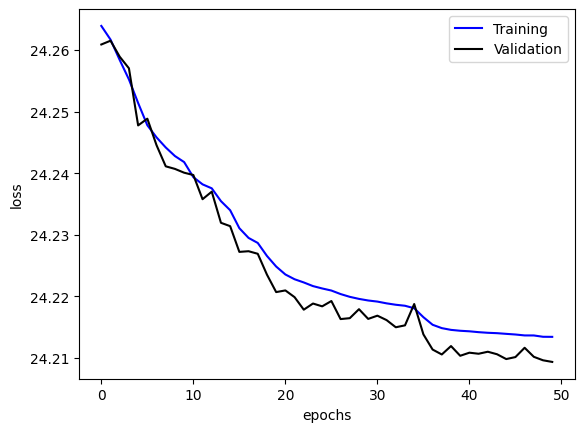

In [ ]:
## Build and compile the DNN model
## Training and Testing
import matplotlib.pyplot as plt

Opt_Adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = Opt_Adam, loss = custom_loss_DC3)

train_input = [train_input_F_H_shuffled, train_input_EsN0_shuffled]
valid_input = [valid_input_F_H_shuffled, valid_input_EsN0_shuffled]

history = model.fit(train_input, train_y_true, epochs = 50,
                    validation_data = (valid_input, valid_y_true), batch_size = 1000)

plt.plot(history.epoch, history.history['loss'], color = "blue", label = "Training")
plt.plot(history.epoch, history.history['val_loss'], color="black", label = "Validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [36]:
# Test data setup
test_input = [test_input_F_H_0dB, test_input_EsN0_0dB]
output_P_hat_temp = tf.multiply(PMax, model.predict(test_input))  # Predicted power allocation
output_P_hat = tf.reshape(output_P_hat_temp, (tf.shape(output_P_hat_temp)[0], K, 1))  # Reshape to [num_samples, K, 1]
output_P_hat_size = tf.shape(output_P_hat)[0]  # Number of samples
test_data_F_H_abs_sqr = cmplx_abs_sqr(test_data_F_H_0dB)  # Compute squared magnitude of hij

eta = 1e-3  # Learning rate for gradient descent
indx_n = []  # List to store indices of samples with constraint violations
count_v = 0  # Counter for total violations

# Iterate over each test sample
for k in range(output_P_hat_size):
    p = output_P_hat[k]  # Initial power vector for this sample, shape [K, 1]
    hij_abs_sqr = test_data_F_H_abs_sqr[k]  # hij squared magnitude for this sample, shape [K, K]
    sigma_sqr_noise_0dB_sample = sigma_sqr_noise_0dB  # Use constant noise variance for all samples

    # Ensure consistent data types
    p = tf.cast(p, dtype=tf.float32)
    hij_abs_sqr = tf.cast(hij_abs_sqr, dtype=tf.float32)
    sigma_sqr_noise_0dB_sample = tf.cast(sigma_sqr_noise_0dB_sample, dtype=tf.float32)
    SINR_P_min = tf.cast(SINR_P_min, dtype=tf.float32)

    # Generate matrices A, b, A_tilda, and B_tilda for this sample
    A = generate_A(1, K, SINR_P_min, hij_abs_sqr)
    b = generate_b(1, K, SINR_P_min, sigma_sqr_noise_0dB_sample, hij_abs_sqr)
    A_tilda = generate_A_tilda(A, K)
    B_tilda = generate_B_tilda(b, K)
    A_tilda_T = transpose_A_tilda(A_tilda)

    # Perform gradient descent for 5 iterations
    for i in range(5):
        V = B_tilda - tf.linalg.matmul(A_tilda, p)
        V_relu = tf.nn.relu(V)  # Apply ReLU to the result
        gd = 2 * tf.linalg.matmul(A_tilda_T, V_relu)  # Gradient descent update
        p = p + eta * gd  # Update power allocation

    # Check for SINR constraint violations after applying gradient descent
    for i in range(K):  # Iterate over each user
        ph = tf.reduce_sum(tf.multiply(p, hij_abs_sqr[i, :]))  # Interference + noise
        numr = tf.multiply(p[i], hij_abs_sqr[i, i])  # Signal power (numerator)
        dnumr = sigma_sqr_noise_0dB_sample[i] + ph - numr  # Denominator of SINR
        SINR_out = tf.divide(numr, dnumr)  # Compute SINR

        # Round SINR to 3 decimal places and check for violations
        SINR_out_rounded = tf.round(SINR_out * 1000) / 1000

        # Perform element-wise comparison and reduce to check for any violations
        violation = tf.reduce_any(SINR_out_rounded < SINR_P_min[i])
        if violation:
            indx_n.append(k)  # Store index of sample with violation
            count_v += 1  # Increment violation counter
            break  # Stop checking further users for this sample

# Calculate violation probability
violation_prb = (count_v / output_P_hat_size.numpy()) * 100
print("Constraints Violation Probability: {:.2f}%".format(violation_prb))




782/782 [==============================] - 1s 1ms/step
Constraints Violation Probability: 100.00%


In [ ]:
# Test data setup
test_input = [test_input_F_H_0dB, test_input_EsN0_0dB]
output_P_hat_temp = tf.multiply(PMax, model.predict(test_input))  # Predicted power allocation
output_P_hat = tf.reshape(output_P_hat_temp, (tf.shape(output_P_hat_temp)[0], K, 1))  # Reshape to [num_samples, K, 1]
output_P_hat_size = tf.shape(output_P_hat)[0]  # Number of samples
test_data_F_H_abs_sqr = cmplx_abs_sqr(test_data_F_H_0dB)  # Compute squared magnitude of hij

eta = 1e-3  # Learning rate for gradient descent
indx_n = []  # List to store indices of samples with constraint violations
count_v = 0  # Counter for total violations

# Iterate over each test sample
for k in range(output_P_hat_size):
    p = output_P_hat[k]  # Initial power vector for this sample, shape [K, 1]
    hij_abs_sqr = test_data_F_H_abs_sqr[k]  # hij squared magnitude for this sample, shape [K, K]
    sigma_sqr_noise_0dB_sample = sigma_sqr_noise_0dB[k]  # Noise variance for this sample


    # Ensure consistent data types
    p = tf.cast(p, dtype=tf.float32)  # Already float32, but ensuring consistency
    hij_abs_sqr = tf.cast(hij_abs_sqr, dtype=tf.float32)  # Cast to float32
    sigma_sqr_noise_0dB_sample = tf.cast(sigma_sqr_noise_0dB_sample, dtype=tf.float32)  # Cast to float32


    # Generate matrices A, b, A_tilda, and B_tilda for this sample
    A = generate_A(1, K, SINR_P_min, hij_abs_sqr)
    b = generate_b(1, K, SINR_P_min, sigma_sqr_noise_0dB, hij_abs_sqr)
    A_tilda = generate_A_tilda(A, K)
    B_tilda = generate_B_tilda(b, K)
    A_tilda_T = transpose_A_tilda(A_tilda)

    # Perform gradient descent for 5 iterations
    for i in range(5):
        V = B_tilda - tf.linalg.matmul(A_tilda, p)
        V_relu = tf.nn.relu(V)  # Apply ReLU to the result
        gd = 2 * tf.linalg.matmul(A_tilda_T, V_relu)  # Gradient descent update
        p = p + eta * gd  # Update power allocation

    # Check for SINR constraint violations after applying gradient descent
    for i in range(K):  # Iterate over each user
        ph = tf.reduce_sum(tf.multiply(p, hij_abs_sqr[i, :]))  # Interference + noise
        numr = tf.multiply(p[i], hij_abs_sqr[i, i])  # Signal power (numerator)
        dnumr = sigma_sqr_noise_0dB[i] + ph - numr  # Denominator of SINR
        SINR_out = tf.divide(numr, dnumr)  # Compute SINR

        # # Check if SINR is below the minimum required value
        if tf.round(SINR_out, decimals=3) < SINR_P_min[i]:
            indx_n.append(k)  # Store index of sample with violation
            count_v += 1  # Increment violation counter
            break  # Stop checking further users for this sample

# Calculate violation probability
violation_prb = (count_v / output_P_hat_size.numpy()) * 100
print("Constraints Violation Probability: {:.2f}%".format(violation_prb))


In [ ]:
## Updated test code in TensorFlow to apply gradient descent on test data

test_input = [test_input_F_H_0dB, test_input_EsN0_0dB]
output_P_hat_temp = tf.multiply(PMax, model.predict(test_input))
output_P_hat = tf.reshape(output_P_hat_temp, (tf.shape(output_P_hat_temp)[0], tf.shape(output_P_hat_temp)[1], 1)) # test_input_F_H_size X row X column
output_P_hat_size = tf.shape(output_P_hat)[0]
test_data_F_H_abs_sqr = cmplx_abs_sqr(test_data_F_H_0dB)

eta = 1e-3  # Same learning rate used in the gradient descent

indx_n = []
count_v = 0

for k in range(output_P_hat_size):
    p = output_P_hat[k]  # Initial power vector for this sample
    hij_abs_sqr = test_data_F_H_abs_sqr[k]  # hij squared magnitude for this sample

    # Generate matrices A, b, A_tilda, and B_tilda for this sample
    A = generate_A(1, K, SINR_P_min, hij_abs_sqr)
    b = generate_b(1, K, SINR_P_min, sigma_sqr_noise_0dB, hij_abs_sqr)
    A_tilda = generate_A_tilda(A, K)
    B_tilda = generate_B_tilda(b, K)
    A_tilda_T = transpose_A_tilda(A_tilda)

    # Perform gradient descent on this sample
    for i in range(5):
        V = B_tilda - tf.linalg.matmul(A_tilda, p)
        V_relu = tf.nn.relu(V)  # ReLU operation
        gd = 2 * tf.linalg.matmul(A_tilda_T, V_relu)
        p = p + eta * gd  # Update the power allocation

    # Check for SINR constraint violations after applying gradient descent
    for i in range(K):  # Total rows
        ph = 0
        for j in range(K):  # Total columns
            ph_j = tf.multiply(p[j], hij_abs_sqr[i, j])
            ph = ph + ph_j

        numr = tf.multiply(p[i], hij_abs_sqr[i, i])
        dnumr = sigma_sqr_noise_0dB[i] + ph - numr
        SINR_out = tf.divide(numr, dnumr)

        # Check if the SINR is below the minimum required value
        if tf.round(SINR_out, decimals=3) < SINR_P_min[i]:
            indx_n.append(k)
            count_v += 1
            break

# Calculate violation probability
violation_prb = (count_v / output_P_hat_size.numpy()) * 100
print("Constraints Violation Probability: {:.2f}%".format(violation_prb))


In [ ]:
## Constraint violation probability and
## finding indexes of test_input_F_H matrix with the hij set that do not satisfy
## constraint on the minimum SINR_P_min rate but satisfy the maximum transmit
## power PMax

test_input = [test_input_F_H_0dB, test_input_EsN0_0dB]
# output_P_hat_temp = model.predict(test_input)
output_P_hat_temp = np.multiply(PMax, model.predict(test_input))
output_P_hat = output_P_hat_temp.reshape((output_P_hat_temp.shape[0], output_P_hat_temp.shape[1], 1)) # test_input_F_H_size X row X column
output_P_hat_size = output_P_hat.shape[0]
test_data_F_H_abs_sqr = cmplx_abs_sqr(test_data_F_H_0dB)

indx_n = []
count_v = 0

for k in range(output_P_hat_size):
  for i in range(K):  # Total rows
    ph = 0
    for j in range(K):  # Total columns
      ph_j = np.multiply(output_P_hat[k,j], test_data_F_H_abs_sqr[k,i,j])
      ph = ph + ph_j

    numr = np.multiply(output_P_hat[k,i], test_data_F_H_abs_sqr[k,i,i])
    dnumr = sigma_sqr_noise_0dB[i] + ph - numr
    SINR_out = np.divide(numr, dnumr)

    if np.round(SINR_out, decimals= 3) < SINR_P_min[i]:
      indx_n.append(k)
      count_v = count_v + 1
      # print(SINR_out)
      break

violation_prb = (count_v / output_P_hat_size) * 100
print("Constraints Violation Probability: {:.2f}%".format(violation_prb))
# print(len(indx_n))
# print(indx_n)

782/782 [==============================] - 1s 1ms/step
Constraints Violation Probability: 94.46%


In [ ]:
## Function to calculate the average sum rate
# Here, p_model is the output of DNN, and it is a 2D array.
import math

def average_sum_rate(hij, p_model, sigma_sqr_noise, K):
  R = 0
  hij_size = hij.shape[0]
  hij_abs_sqr = cmplx_abs_sqr(hij)

  for k in range(hij_size):
    for i in range(K):  # Total rows
      phn = 0
      for j in range(K):  # Total columns
        phn_j = np.multiply(p_model[k,j], hij_abs_sqr[k,i,j])
        phn = phn + phn_j

      numr_s = np.multiply(p_model[k,i], hij_abs_sqr[k,i,i])
      dnumr_s = sigma_sqr_noise[i] + phn - numr_s
      R_temp = math.log2(1 + np.divide(numr_s, dnumr_s))
      R = R + R_temp

  return (R/hij_size)

In [ ]:
## DNN Sum Rate for test_data_F_H
sumrate_F_H = average_sum_rate(test_input[0], model.predict(test_input),sigma_sqr_noise_0dB, K)
print("Average Sum Rate for all H matrices: {:.3f} Bit/Second/Hertz".format(sumrate_F_H))

782/782 [==============================] - 1s 1ms/step
Average Sum Rate for all H matrices: 1.910 Bit/Second/Hertz
